In [8]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
from pypylon import pylon
from basler_camera import BaslerCamera, list_basler_cameras
import subprocess as sp
import os
import traceback

# list available cameras
print("Cameras Available:")
cameras = list_basler_cameras()

# Acquisition Parameters
EXPOSURE_TIME, GAIN, CAMERA_FORMAT, WIDTH, HEIGHT, OFFSETX, OFFSETY = 7000.0, 0.0, "Mono8", 2048, 2048, 248, 0

Cameras Available:
a2A2448-105g5m_40490701


In [2]:
# get a single image from the camera
with BaslerCamera(
    index=0,
    FPS=100,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    image = camera.get_array()
    camera.stop()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (248, 0).
Camera initialized.


Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (248, 0).
Camera initialized.


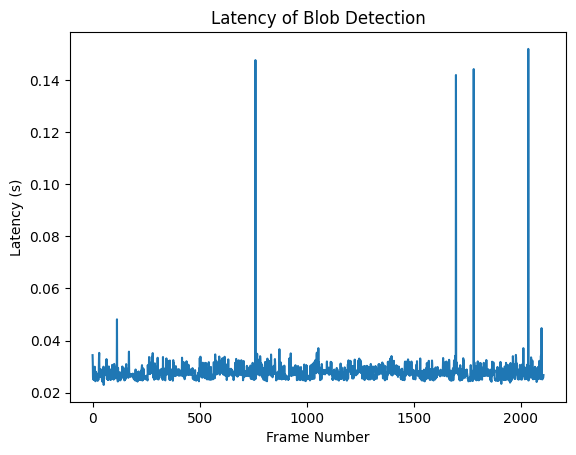

In [13]:
# Acquisition Parameters
EXPOSURE_TIME, GAIN, CAMERA_FORMAT, WIDTH, HEIGHT, OFFSETX, OFFSETY = 7000.0, 0.0, "Mono8", 2048, 2048, 248, 0

# Create Background Subtractor using CPU (as CUDA version is not available)
background_subtractor = cv2.createBackgroundSubtractorMOG2()

# Create Blob Detector Parameters
blob_params = cv2.SimpleBlobDetector_Params()
blob_params.filterByArea = True
blob_params.minArea = 100   # Minimum area of the blob
blob_params.filterByCircularity = False
blob_params.filterByConvexity = False
blob_params.filterByInertia = False
blob_detector = cv2.SimpleBlobDetector_create(blob_params)

# create named windows
cv2.namedWindow('Foreground Mask', cv2.WINDOW_NORMAL)
cv2.namedWindow('Blob Detection', cv2.WINDOW_NORMAL)

# set window properties
cv2.resizeWindow('Foreground Mask', 800, 800)
cv2.resizeWindow('Blob Detection', 800, 800)

latencies = []
positions = []

# Camera Capture
with BaslerCamera(
    index=0,
    FPS=FPS,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    
    current_time = time.perf_counter()

    while True:
        # Capture frame-by-frame
        image = camera.get_array()
        if image is None:
            continue
        
        # Background Subtraction
        fg_mask = background_subtractor.apply(image, learningRate=0.0001)

        # Blob Detection
        keypoints = blob_detector.detect(fg_mask)

        # Get the positions of the detected blobs
        positions = [keypoint.pt for keypoint in keypoints]
        
        # Draw detected blobs as red circles
        output_frame = cv2.drawKeypoints(image, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        
        # Display the resulting frame
        cv2.imshow('Foreground Mask', fg_mask)
        cv2.imshow('Blob Detection', output_frame)

        # Calculate Latency
        new_time = time.perf_counter()
        latencies.append(new_time - current_time)
        current_time = new_time
        
        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # When everything is done, release the capture
    camera.stop()
    cv2.destroyAllWindows()

# Plot Latency in seconds
plt.plot(latencies)
plt.xlabel('Frame Number')
plt.ylabel('Latency (s)')
plt.title('Latency of Blob Detection')
plt.show()

In [7]:
import cv2
import numpy as np
from basler_camera import BaslerCamera

# Parameters
FPS = 100
# Acquisition Parameters
EXPOSURE_TIME, GAIN, CAMERA_FORMAT, WIDTH, HEIGHT, OFFSETX, OFFSETY = 7000.0, 0.0, "Mono8", 2048, 2048, 248, 0

# Initialize a background model to store the lightest frames
background_model = None

# create named windows
cv2.namedWindow('Foreground Mask', cv2.WINDOW_NORMAL)
cv2.namedWindow('Blob Detection', cv2.WINDOW_NORMAL)

# set window properties
cv2.resizeWindow('Foreground Mask', 800, 800)
cv2.resizeWindow('Blob Detection', 800, 800)

# Camera Capture
with BaslerCamera(
    index=0,
    FPS=FPS,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    
    while True:
        # Capture frame-by-frame
        gray_frame = camera.get_array()
        if gray_frame is None:
            continue
        
        # Initialize background model with the first frame
        if background_model is None:
            background_model = gray_frame.astype(np.float32)
            continue
        
        # Update background model by keeping the lightest pixels
        cv2.accumulateWeighted(src=gray_frame, dst=background_model, alpha=0.001, mask=None)
        background_model_uint8 = cv2.convertScaleAbs(background_model)
        background_model_uint8 = np.maximum(background_model_uint8, gray_frame)

        # Background Subtraction to get foreground mask
        fg_mask = cv2.absdiff(background_model_uint8, gray_frame)
        _, fg_mask = cv2.threshold(fg_mask, 50, 255, cv2.THRESH_BINARY)
        
        # Apply a bit of morphological operations to reduce noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
        
        # Display the resulting frame
        cv2.imshow('Foreground Mask', fg_mask)
        cv2.imshow('Blob Detection', gray_frame)
        
        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # When everything is done, release the capture
    camera.stop()
    cv2.destroyAllWindows()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (248, 0).
Camera initialized.


In [5]:
import cv2
import numpy as np
import time
from basler_camera import BaslerCamera

# Parameters
FPS = 100
# Acquisition Parameters
EXPOSURE_TIME, GAIN, CAMERA_FORMAT, WIDTH, HEIGHT, OFFSETX, OFFSETY = 7000.0, 0.0, "Mono8", 2048, 2048, 248, 0

# Initialize background models
background_model_lightest = None

# # create named windows
cv2.namedWindow('Foreground Mask', cv2.WINDOW_NORMAL)
cv2.namedWindow('Blob Detection', cv2.WINDOW_NORMAL)
cv2.namedWindow('Lightest Background', cv2.WINDOW_NORMAL)

# # set window properties
cv2.resizeWindow('Foreground Mask', 800, 800)
cv2.resizeWindow('Blob Detection', 800, 800)
cv2.resizeWindow('Lightest Background', 800, 800)

fpses = []

# Camera Capture
with BaslerCamera(
    index=0,
    FPS=FPS,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    
    # Start time to calculate FPS
    start_time = time.time()
    frame_count = 0
    
    while True:
        # Capture frame-by-frame
        gray_frame = camera.get_array()
        if gray_frame is None:
            continue
        
        # Initialize lightest background model with the first frame
        if background_model_lightest is None:
            background_model_lightest = gray_frame.astype(np.float32)
            continue
        
        # Update lightest background model by keeping the lightest pixels
        background_model_lightest = np.maximum(background_model_lightest, gray_frame.astype(np.float32))
        background_model_lightest_uint8 = cv2.convertScaleAbs(background_model_lightest)

        # Background Subtraction to get foreground mask
        fg_mask = cv2.absdiff(background_model_lightest_uint8, gray_frame)
        _, fg_mask = cv2.threshold(fg_mask, 50, 255, cv2.THRESH_BINARY)
        
        # Apply a bit of morphological operations to reduce noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
        
        # Display the resulting frames
        cv2.imshow('Foreground Mask', fg_mask)
        cv2.imshow('Blob Detection', gray_frame)
        cv2.imshow('Lightest Background', background_model_lightest_uint8)
        
        # Calculate and display FPS
        frame_count += 1
        elapsed_time = time.time() - start_time
        if elapsed_time > 0:
            fps = frame_count / elapsed_time
            fpses.append(fps)
            # print(f"FPS: {fps:.2f}")
        
        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # When everything is done, release the capture
    camera.stop()
    cv2.destroyAllWindows()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (248, 0).
Camera initialized.


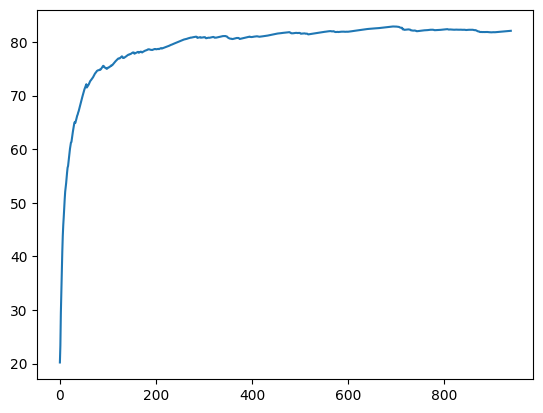

In [9]:
plt.plot(fpses)

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (248, 0).
Camera initialized.


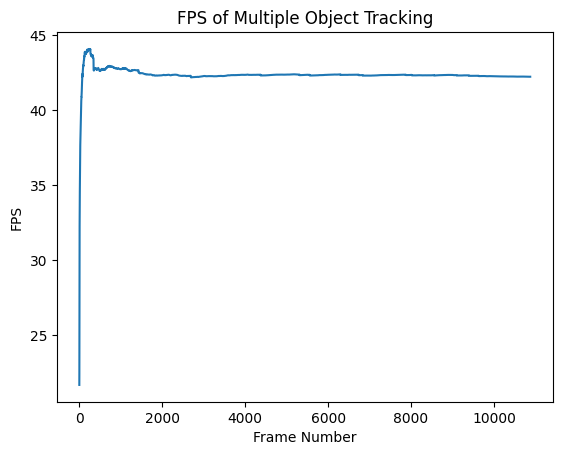

In [18]:
import cv2
import numpy as np
import time
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
from basler_camera import BaslerCamera
import matplotlib.pyplot as plt

# Parameters
FPS = 100
MAX_TARGETS = 8  # User can specify the number of animals to track
EXPOSURE_TIME = 7000.0
GAIN = 0.0
CAMERA_FORMAT = "Mono8"
WIDTH = 2048
HEIGHT = 2048
OFFSETX = 248
OFFSETY = 0
KALMAN_NOISE_COVARIANCE = 0.03  # Process noise covariance for Kalman Filter
MORPH_KERNEL_SIZE = 5  # Size of the kernel for morphological operations
THRESHOLD_VALUE = 50  # Threshold value for foreground mask extraction
TRAJECTORY_THICKNESS = 2  # Thickness of the trajectory lines
TRAJECTORY_HISTORY_SECONDS = 5  # Keep last 5 seconds of trajectory
TRAJECTORY_COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Colors for different trajectories

# Initialize background model
background_model_lightest = None

# Kalman Filters for tracking multiple targets
kalman_filters = [cv2.KalmanFilter(4, 2) for _ in range(MAX_TARGETS)]
track_ids = list(range(1, MAX_TARGETS + 1))  # Assign IDs to each Kalman filter
predicted_positions = [None] * MAX_TARGETS  # Store predicted positions
trajectories = [[] for _ in range(MAX_TARGETS)]  # Store trajectories of each target
for kf in kalman_filters:
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kf.processNoiseCov = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 5, 0], [0, 0, 0, 5]], np.float32) * KALMAN_NOISE_COVARIANCE

# create named windows
cv2.namedWindow('Foreground Mask', cv2.WINDOW_NORMAL)
cv2.namedWindow('Blob Detection', cv2.WINDOW_NORMAL)
cv2.namedWindow('Lightest Background', cv2.WINDOW_NORMAL)

# set window properties
cv2.resizeWindow('Foreground Mask', 800, 800)
cv2.resizeWindow('Blob Detection', 800, 800)
cv2.resizeWindow('Lightest Background', 800, 800)

fpses = []

# Camera Capture
with BaslerCamera(
    index=0,
    FPS=FPS,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    
    # Start time to calculate FPS
    start_time = time.time()
    frame_count = 0
    
    while True:
        # Capture frame-by-frame
        gray_frame = camera.get_array()
        if gray_frame is None:
            continue
        current_time = time.time()
        
        # Initialize lightest background model with the first frame
        if background_model_lightest is None:
            background_model_lightest = gray_frame.astype(np.float32)
            continue
        
        # Update lightest background model by keeping the lightest pixels
        background_model_lightest = np.maximum(background_model_lightest, gray_frame.astype(np.float32))
        background_model_lightest_uint8 = cv2.convertScaleAbs(background_model_lightest)

        # Background Subtraction to get foreground mask
        fg_mask = cv2.absdiff(background_model_lightest_uint8, gray_frame)
        _, fg_mask = cv2.threshold(fg_mask, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
        
        # Apply a bit of morphological operations to reduce noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_KERNEL_SIZE, MORPH_KERNEL_SIZE))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
        
        # Find contours of the foreground objects
        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Fit ellipses to detected contours and track them
        measurements = []
        if len(contours) > 0:
            for cnt in contours:
                if len(cnt) >= 5:  # Minimum points to fit an ellipse
                    ellipse = cv2.fitEllipse(cnt)
                    (x, y), (MA, ma), angle = ellipse
                    measurements.append(np.array([np.float32(x), np.float32(y)]))
        
        # Update Kalman filters and assign IDs to measurements
        if measurements:
            # Predict next positions of all Kalman filters
            for i, kf in enumerate(kalman_filters):
                predicted = kf.predict()
                predicted_positions[i] = (predicted[0], predicted[1])
            
            # Create cost matrix for Hungarian algorithm
            cost_matrix = np.zeros((MAX_TARGETS, len(measurements)))
            for i, predicted_pos in enumerate(predicted_positions):
                for j, measurement in enumerate(measurements):
                    cost_matrix[i, j] = distance.euclidean(np.array(predicted_pos).flatten(), measurement.flatten())
            
            # Solve assignment problem using Hungarian algorithm
            row_indices, col_indices = linear_sum_assignment(cost_matrix)
            
            # Assign measurements to Kalman filters
            for row, col in zip(row_indices, col_indices):
                if row < MAX_TARGETS and col < len(measurements):
                    kalman_filters[row].correct(np.array([[measurements[col][0]], [measurements[col][1]]], np.float32))
                    # Update the trajectory for the assigned Kalman filter
                    trajectories[row].append((int(measurements[col][0]), int(measurements[col][1]), current_time))
                    # Keep only the last TRAJECTORY_HISTORY_SECONDS seconds of trajectory
                    trajectories[row] = [(x, y, t) for x, y, t in trajectories[row] if current_time - t <= TRAJECTORY_HISTORY_SECONDS]
        
        # Draw tracked objects, IDs, and trajectories
        for i, kf in enumerate(kalman_filters):
            predicted = kf.predict()
            x, y = int(predicted[0]), int(predicted[1])
            # Draw the ellipse over the trails
            cv2.circle(gray_frame, (x, y), 10, (0, 0, 255), -1)
            # Display the ID of the tracked object
            cv2.putText(gray_frame, f"ID: {track_ids[i]}", (x + 15, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            # Draw the trajectory of each target
            for point_idx in range(1, len(trajectories[i])):
                pt1 = (trajectories[i][point_idx - 1][0], trajectories[i][point_idx - 1][1])
                pt2 = (trajectories[i][point_idx][0], trajectories[i][point_idx][1])
                cv2.line(gray_frame, pt1, pt2, TRAJECTORY_COLORS[i % len(TRAJECTORY_COLORS)], TRAJECTORY_THICKNESS)
        
        # Display the resulting frames
        cv2.imshow('Foreground Mask', fg_mask)
        cv2.imshow('Blob Detection', gray_frame)
        cv2.imshow('Lightest Background', background_model_lightest_uint8)
        
        # Calculate and display FPS
        frame_count += 1
        elapsed_time = time.time() - start_time
        if elapsed_time > 0: 
            fps = frame_count / elapsed_time
            fpses.append(fps)
        
        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # When everything is done, release the capture
    camera.stop()
    cv2.destroyAllWindows()

# Plot FPS
fig, ax = plt.subplots()
ax.plot(fpses)
ax.set_xlabel('Frame Number')
ax.set_ylabel('FPS')
ax.set_title('FPS of Multiple Object Tracking')
plt.show()

In [14]:
fpses

[19.45148379856142,
 21.72364696711908,
 25.117397657316694,
 27.394548592571546,
 28.935693461172825,
 28.994321147245774,
 29.603170025912743,
 29.901513592029694,
 30.847930545295267,
 31.096467685445774,
 31.698077326050736,
 32.0502088639837,
 32.78606780298999,
 32.97175514311094,
 33.43255917761122,
 33.73276023699286,
 34.09476584917777,
 34.346102019072504,
 34.596372779873164,
 34.627439389861514,
 34.80896018564698,
 34.794534515239135,
 35.06164364393397,
 35.05852450446541,
 35.32401242264063,
 35.38198214157672,
 35.741313228736914,
 35.86714554472379,
 35.98727077995467,
 36.11741010266969,
 36.383469770083906,
 36.470553646070954,
 36.66624511214419,
 36.79035588573103,
 36.96015621892201,
 36.93109088067458,
 37.11559510681159,
 37.156708387185816,
 37.30115938849742,
 37.344212289219485,
 37.45313938116219,
 37.50038700843755,
 37.70066327053202,
 37.70174762644684,
 37.813495392208694,
 37.91082041609594,
 38.096920781046414,
 38.161230278386654,
 38.275176685766304,